In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
screen_name = 'ola_supports'
db = MongoClient().get_database('not-truncated')
convs = list(db.conversations.find({'screen_name': screen_name, 'topics': {'$ne': []}}))
print('There are total', len(convs), 'conversations')

There are total 603 conversations


In [3]:
# flatten it

dataset = []
topics_to_ignore = ['undefined', 'poor_experience', 'random_query']
cant_coexist = [
    ('overcharged', 'payments'),
    ('cancellation_charged', 'overcharged'),
    ('driver_denied', 'cancellation_charged'),
]
# cant_coexist = []

for c in convs:
    topics_here = [t for t in c['topics'] if t not in topics_to_ignore]
    
    # manually remove second topic from pairs if they co-exist
    for to_keep, to_discard in cant_coexist:
        if to_keep in topics_here and to_discard in topics_here:
            topics_here.remove(to_discard)
    
    
    for m in filter(lambda msg: msg['important'], c['messages']):
        for t in topics_here:
            dataset.append({'message': m['processed_text'].replace('\n', ''), 'topic': t})
        
df = pd.DataFrame(dataset)
print(df.size, 'records')

df.head()

1730 records


,message,topic
0,"Hi Hetan, we are sorry for the denial. We have...",delay
1,"Hi Hetan, we are sorry for the denial. We have...",driver_denied
2,"What a morning ride Booked a mini cab, waited...",delay
3,"What a morning ride Booked a mini cab, waited...",driver_denied
4,I would like to know what action was taken reg...,ola_share


driver_denied           177
overcharged             140
misbehaviour            124
delay                    88
app_issue                87
customer_support         73
payments                 64
cancellation_charged     36
ola_share                22
ola_auto                 21
no_service               20
promo_codes               8
ola_outstation            5
Name: topic, dtype: int64


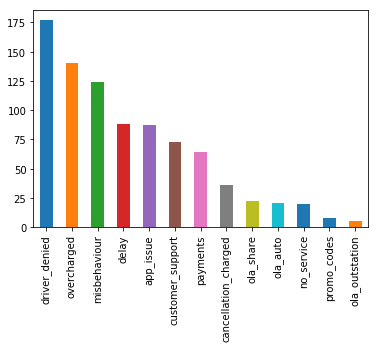

In [4]:
topic_counts = df['topic'].value_counts()
print(topic_counts)
topic_counts.plot.bar()

50 is the cutoff frequency
Selected topics are ['driver_denied' 'overcharged' 'misbehaviour' 'delay' 'app_issue'
 'customer_support' 'payments']
1730 records reduced to 1506 records


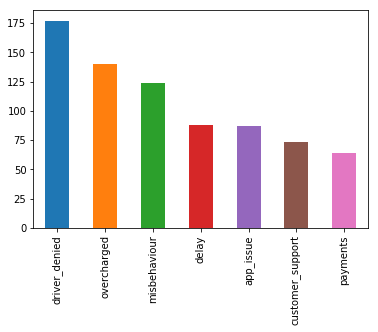

In [5]:
# remove values below a certain frequency
cutoff_freq = int(0.15 * len(convs))
cutoff_freq = 50
print(cutoff_freq, 'is the cutoff frequency')
selected_topics = topic_counts[topic_counts > cutoff_freq]
print('Selected topics are', selected_topics.index.values)

l1 = df.size
df = df.loc[df['topic'].isin(selected_topics.index.values)]
l2 = df.size
print(l1, 'records reduced to', l2, 'records')

original_df = df.copy()

df['topic'].value_counts().plot.bar()

[91 95 97]
delay               88
app_issue           87
customer_support    73
payments            64
Name: topic, dtype: int64
Total 312 entries


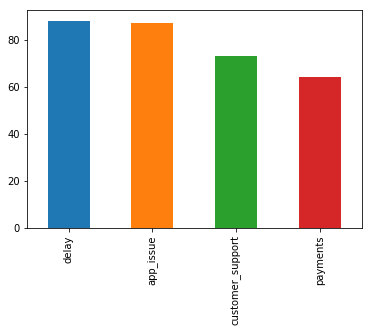

In [6]:
# undersampling more frequent topics
df = original_df.copy()

median_freq = selected_topics.median().astype(int)
topics_to_undersample = selected_topics[selected_topics > median_freq].index.values

# get `median_freq + small random number` records for each topic to be undersampled
undersampling_freq = (np.random.rand(len(topics_to_undersample)) * 10).astype(int) + median_freq
print(undersampling_freq)
undersampled_dfs = [df[df['topic'] == topic].sample(count) 
                    for count, topic in zip(undersampling_freq,  topics_to_undersample)]

for topic, undersampled_one in zip(topics_to_undersample, undersampled_dfs):
    df = df[df['topic'] != topic]
    df.append(undersampled_one)

topic_counts = df['topic'].value_counts()
print(topic_counts)
print('Total', topic_counts.sum(), 'entries')
topic_counts.plot.bar()

In [7]:
# # oversampling less frequent topics
# df = original_df.copy()

# median_freq = selected_topics.median().astype(int)
# topics_to_oversample = selected_topics[selected_topics < median_freq].index.values
# print(topics_to_oversample)

# # get `median_freq + small random number` records for each topic to be undersampled
# oversampling_freq = median_freq - (np.random.rand(len(topics_to_undersample)) * 10).astype(int)
# print(oversampling_freq)
# oversampled_dfs = [pd.concat(df[df['topic'] == topic] * math.ceil(count / selected_topics[topic])
#                    for count, topic in zip(oversampling_freq,  topics_to_oversample)]

# for topic, undersampled_one in zip(topics_to_undersample, undersampled_dfs):
#     df = df[df['topic'] != topic]
#     df.append(undersampled_one)

# topic_counts = df['topic'].value_counts()
# print(topic_counts)
# print('Total', topic_counts.sum(), 'entries')
# topic_counts.plot.bar()

In [8]:
df['topic_id'] = df['topic'].factorize()[0]

topic_id_df = df[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

In [11]:
# text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', 
                        ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.message).toarray()
labels = df['topic_id']
features.shape
features[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.70734748, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
# find most correlated topics
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split()) == 1]
    bigrams = [v for v in feature_names if len(v.split()) == 2]
    trigrams = [v for v in feature_names if len(v.split()) == 3]
    print('For', topic)
    print('\t', 'Unigrams >', unigrams[-N:])
    print('\t', 'Bigrams >', bigrams[-N:])
#     print('\t', 'Trigrams >', trigrams[-N:])

For app_issue
	 Unigrams > ['working', 'app']
	 Bigrams > ['ola app', 'ola money']
For customer_support
	 Unigrams > ['number', 'customer']
	 Bigrams > ['customer service', 'customer care']
For delay
	 Unigrams > ['late', 'drop']
	 Bigrams > ['ola money', '30 mins']
For payments
	 Unigrams > ['money', 'payment']
	 Bigrams > ['ola credit', 'ola money']


In [12]:
# training on a Naive Bayes Classifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours as ENN

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['topic'], random_state=0)
# This won't work. X_train is string and would cause value error. 
# Thus, first vectorize it, then apply SMOTE
# X_train, Y_train = SMOTE(random_state=0, ratio=1.0).fit_sample(X_train, Y_train)

X_train_counts = count_vect.fit_transform(X_train)

# X and Y from tfidf
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# SMOTE for oversampling
X_train_tfidf_sm, Y_train_sm = SMOTE(random_state=0).fit_sample(X_train_tfidf, Y_train)

# ENN for under sampling
X_train_tfidf_enn, Y_train_enn = ENN().fit_sample(X_train_tfidf, Y_train)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

models = {
    'random_forest': RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    'support_vector': LinearSVC(),
    'multinomial_nb': MultinomialNB(),
    'logistic_regression': LogisticRegression(random_state=0),
}

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models.values():
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

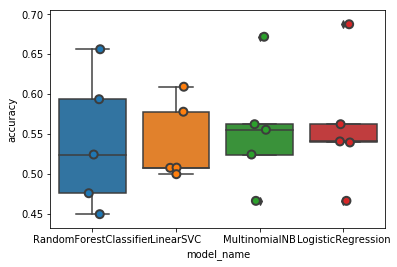

In [14]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
             size=8, jitter=True, linewidth=2)
plt.show()

NameError: name 'Y_pred' is not defined

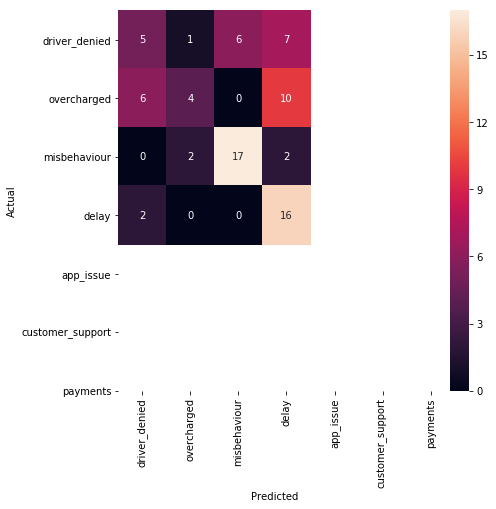

In [15]:
# training on a Naive Bayes Classifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['topic'], random_state=0)
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

model = LogisticRegression()
sm = SMOTE(random_state=0)
X_train_res, Y_train_res = sm.fit_sample(X_train_tfidf, Y_train)
clf = model.fit(X_train_res, Y_train_res)
accuracies = cross_val_score(clf, features, labels, scoring='accuracy', cv=CV)

from sklearn.metrics import confusion_matrix

# Y_pred = model.predict(tfidf_transformer.transform(count_vect.transform(X_test)))
Y_pred = model.predict(count_vect.transform(X_test))

conf_mat = confusion_matrix(Y_test, Y_pred)
n_topics = len(selected_topics)
fig, ax = plt.subplots(figsize=(n_topics, n_topics))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=selected_topics.index.values,
            yticklabels=selected_topics.index.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
text = 'i am waiting for driver for more than 2 hours. extremely poor experience'
text = 'driver refuses to pick from airport. what the fuck?'
clf.predict(count_vect.transform([text]))

accuracy 0.30687830687830686
recall 0.30687830687830686
precision 0.30687830687830686


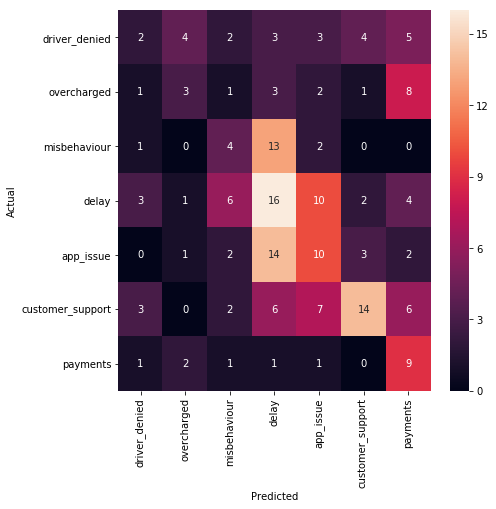

In [40]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours as ENN

from sklearn.metrics import recall_score, precision_score, accuracy_score

# pipeline = make_pipeline(
# #     CountVectorizer(),
#     TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', 
#                     ngram_range=(1, 2), stop_words='english'),
#     SMOTE(),
# #     ENN(),
#     MultinomialNB(),
# )

# clf = pipeline.fit(X_train, Y_train)
clf = MultinomialNB().fit(X_train_tfidf_sm, Y_train_sm)
Y_pred = clf.predict(count_vect.transform(X_test))

print('accuracy', accuracy_score(Y_test, Y_pred))
print('recall', recall_score(Y_test, Y_pred, average='micro'))
print('precision', precision_score(Y_test, Y_pred, average='micro'))

conf_mat = confusion_matrix(Y_test, Y_pred)
n_topics = len(selected_topics)
fig, ax = plt.subplots(figsize=(n_topics, n_topics))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=selected_topics.index.values,
            yticklabels=selected_topics.index.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()